<a href="https://colab.research.google.com/github/dj311/uob-summer-project/blob/master/code/ML_adj_matrix_conv_neural_network_vdisc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup

In [341]:
!mkdir -p /project/data && cd /project/data && wget -O vdisc_adj_matrix_withlabel.pickle https://github.com/dj311/uob-summer-project/raw/master/data/vdisc_adj_matrix_withlabel.pickle
!mkdir -p /project/data && cd /project/data && wget -O adjacency-matrix-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-binary.pickle

!mkdir -p /project/code
%cd /project/code

--2019-08-01 14:59:37--  https://github.com/dj311/uob-summer-project/raw/master/data/vdisc_adj_matrix_withlabel.pickle
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/vdisc_adj_matrix_withlabel.pickle [following]
--2019-08-01 14:59:37--  https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/vdisc_adj_matrix_withlabel.pickle
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 746797025 (712M) [application/octet-stream]
Saving to: ‘vdisc_adj_matrix_withlabel.pickle’

vdisc_adj_matrix_wi 100%[===================>] 712.20M   124MB/

# Import & Preprocess Dataset

First we import the data from the [previous notebook](./adjacency_matrix.ipynb).


In [342]:
!pip install sklearn

In [0]:
import tensorflow as tf
import keras
import sklearn
import numpy as np
import pickle
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.model_selection import train_test_split

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
np.random.seed(1248)

tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
import pandas as pd

In [0]:
with open("/project/data/avdisc_adj_matrix_withlabel.pickle", 'rb') as f:
    adj = pickle.load(f)

In [0]:
columns = ['testcase_ID','adj','buffer']

In [0]:
adj = adj[columns]

In [0]:
adj = adj.rename(columns={'testcase_ID': 'testcase_ID', 'adj': 'matrix', 'buffer': 'bug'})

In [475]:
adj.head()

,testcase_ID,matrix,bug
0,vdisc_testcase_0,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",False
1,vdisc_testcase_1,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",False
2,vdisc_testcase_2,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (2, 1...",False
3,vdisc_testcase_5,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 4...",False
4,vdisc_testcase_6,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",False


Next, find out the maximum size of an adjacency matrix, then convert all matrices to have the same dimension.

In [0]:
adj['matrix_size'] = adj.matrix.apply(lambda x: x.shape[0])

In [0]:
adj = adj.loc[adj['matrix_size']>0]

In [478]:
adj.head()

,testcase_ID,matrix,bug,matrix_size
0,vdisc_testcase_0,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",False,60
1,vdisc_testcase_1,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",False,4
2,vdisc_testcase_2,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (2, 1...",False,3
3,vdisc_testcase_5,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 4...",False,36
4,vdisc_testcase_6,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",False,10


So we know that 75% of the dataset has a matrix size <= 614, which is approximately 18000 datapoints. Picking the full dataset would require matrices of dimension 44401x44401 which require 15 gb of memory each. This is isn't feasible, however picking matrices of size 614x614 or less gives a per matrix size of 3.38mb - far more manageable!

In [479]:
matrix_size = 614
adj = adj[adj['matrix_size'] <= matrix_size]
len(adj)

765948

In [480]:
sum(adj.bug), adj.shape

(11453, (765948, 4))

In [488]:
good = adj[adj['bug'] == True].iloc[0:sum(adj.bug)]
bad = adj[adj['bug'] == False].iloc[0:sum(adj.bug)]
len(good), len(bad)

(11453, 11453)

In [489]:
adj_df = pd.concat([good,bad],axis=0)
adj_df

,testcase_ID,matrix,bug,matrix_size
64,vdisc_testcase_84,"(0, 1)\t1\n (0, 2)\t1\n (1, 0)\t1\n (2, 0...",True,4
90,vdisc_testcase_120,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",True,86
117,vdisc_testcase_156,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",True,10
124,vdisc_testcase_164,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 4...",True,30
188,vdisc_testcase_247,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",True,35
288,vdisc_testcase_375,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",True,9
442,vdisc_testcase_575,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 4...",True,7
615,vdisc_testcase_812,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 4...",True,25
623,vdisc_testcase_820,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 4...",True,17
627,vdisc_testcase_824,"(0, 1)\t1\n (1, 0)\t1\n (1, 2)\t1\n (1, 3...",True,31


In [0]:
def bottom_right_matrix_size_corrector(matrix, target_rows, target_columns):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((target_rows-rows, columns))
    col_corrector = csr_matrix((target_rows, target_columns-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix 

In [0]:
adj_df['matrix'] = adj_df['matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size, matrix_size))

In [0]:
testcase_ids = adj_df['testcase_ID'].values
adjacency_matrices = adj_df['matrix'].values
labels = adj_df['bug'].values

Now we have a dataframe for each testcase with a sparse representation of its AST in the matrix column, each normalised to matrix_size x matrix_size in size.
  



Storing all of these matrices in a dense representation at once might cause memory issues. To avoid this, we write a class which generates dense matrices for each of the training batches. 

We also perform the element wrapping as part of this process (since we can't perform it on the sparse arrays, I think).

In [0]:
class SparseToDenseGenerator(keras.utils.Sequence):

    def __init__(self, sparse_matrices, labels, batch_size):
        self.sparse_matrices = sparse_matrices
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_matrices) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse = self.sparse_matrices[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]
        
        batch_dense = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense = np.reshape(batch_dense, batch_dense.shape + (1, ))

        return batch_dense, np.array(batch_labels)

# Model

In [0]:
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as K

In [495]:
batch_size = 96
epochs = 5
num_samples = len(labels)

datapoint_shape = (matrix_size, matrix_size, )
batch_shape = (batch_size, ) + datapoint_shape

steps_per_epoch = int(np.ceil(num_samples/batch_size))

kernel_size = (2, 2)
strides = max(kernel_size[0] // 3, 1)

batch_size, epochs, num_samples, datapoint_shape, batch_shape, steps_per_epoch, kernel_size, strides

(96, 5, 22906, (614, 614), (96, 614, 614), 239, (2, 2), 1)

# Evaluation

In [0]:
model = None
with open('../data/adjacency-matrix-model-binary.pickle','rb') as f:
    model = pickle.load(f)

In [497]:
test_batch_generator = SparseToDenseGenerator(adjacency_matrices, labels, batch_size)

model.evaluate_generator(
    generator=test_batch_generator,
)

[4.093921835991032, 0.43953549420975147]

9833


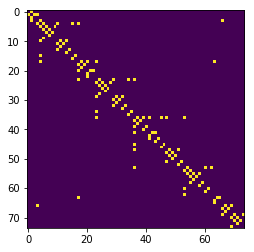

In [498]:
import matplotlib.pyplot as plt
import random
temp = random.randrange(10000)
plt.imshow(adj['matrix'].values[temp].toarray())
print(temp)

In [499]:
print(vdisc.loc[vdisc.testcase_ID == adj.iloc[5520].testcase_ID].iloc[0].code)

gst_auto_convert_internal_src_query (GstPad * pad, GstQuery * query)
{
  GstAutoConvert *autoconvert =
      GST_AUTO_CONVERT (g_object_get_qdata (G_OBJECT (pad),
          parent_quark));
  GstPad *peerpad = gst_pad_get_peer (autoconvert->sinkpad);
  gboolean ret = FALSE;

  if (peerpad) {
    ret = gst_pad_query (peerpad, query);
    gst_object_unref (peerpad);
  }

  return ret;
}


In [0]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [0]:
class SparseToDensePredictGenerator(keras.utils.Sequence):

    def __init__(self, sparse_matrices, batch_size):
        self.sparse_matrices = sparse_matrices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_matrices) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse = self.sparse_matrices[start_index:end_index]
        batch_dense = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense = np.reshape(batch_dense, batch_dense.shape + (1, ))

        return batch_dense

In [0]:
predict_batch_generator = SparseToDensePredictGenerator(adjacency_matrices, batch_size)
y_predict = model.predict_generator(predict_batch_generator)

In [0]:
import numpy as np

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

They predict most of the bug into bug free code.

In [0]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(
    y_test.astype(int),
    np.rint(y_predict),
)

In [0]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

In [0]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    y_test.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [0]:
fpr_nn, fnr_nn

## Random Padding (translational invariance)

In [0]:
import random

In [0]:
def random_padder(matrix, target_rows, target_columns):
    '''
    Randomly pads matrix with zeros to the desired size
    '''
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    rand = random.randint(matrix.shape[0],matrix_size)
    
    tl_row_corrector = csr_matrix((rand-rows, rows))
    tl_col_corrector = csr_matrix((rand, rand-columns))
    
    tl_matrix = vstack([tl_row_corrector, matrix])
    tl_matrix = hstack([tl_col_corrector, tl_matrix])
    
    rows, columns = tl_matrix.shape[0], tl_matrix.shape[1]
    
    br_row_corrector = csr_matrix((target_rows-rows, rows))
    br_col_corrector = csr_matrix((target_columns, target_columns-columns))

    br_matrix = vstack([tl_matrix, br_row_corrector])
    br_matrix = hstack([br_matrix, br_col_corrector])

    br_matrix = br_matrix.astype(np.int)
    
    return br_matrix

In [0]:
rand_adj_df = adj_orig_df.copy()

In [0]:
rand_adj_df['matrix'] = rand_adj_df['matrix'].apply(lambda m: random_padder(m, matrix_size, matrix_size))

In [0]:
testcase_ids_rand = rand_adj_df['testcase_ID'].values
adjacency_matrices_rand = rand_adj_df['matrix'].values
labels_rand = rand_adj_df['bug'].values

In [0]:
rand_adj_df.matrix.iloc[5].toarray().sum()

778

In [0]:
x_train_rand, x_test_rand, y_train_rand, y_test_rand = train_test_split(adjacency_matrices_rand, labels_rand, test_size=0.2, random_state = 0)

Below tests our model above trained on the normal padding against our random padding test set:

In [0]:
test_batch_generator_rand = SparseToDenseGenerator(x_test_rand, y_test_rand, batch_size)

model.evaluate_generator(
    generator=test_batch_generator_rand,
)

[3.4999840995649043, 0.5855548693685892]

In [0]:
predict_batch_generator_rand = SparseToDensePredictGenerator(x_test_rand, batch_size)
y_predict_rand = model.predict_generator(predict_batch_generator)

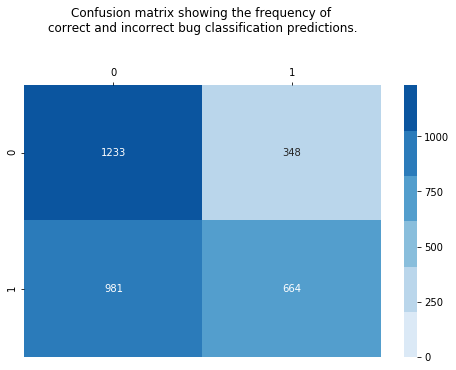

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test_rand, np.rint(y_predict_rand)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(
    y_test_rand.astype(int),
    np.rint(y_predict_rand),
)

In [0]:
auc_keras = auc(fpr_keras, tpr_keras)

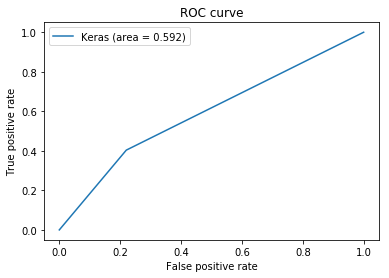

In [0]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    y_test_rand.astype(int), 
    np.rint(y_predict_rand)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

58% accuracy with 3x as more false negatives as there are false positives so our neural network doesn't work the way that we thought it did.

## Training the model on the random padded data

In [0]:
model_rand = Sequential()

model_rand.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
))
model_rand.add(Activation('relu'))
model_rand.add(MaxPooling2D(kernel_size, padding='same'))

model_rand.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    activation='relu',
))
model_rand.add(Activation('relu'))
model_rand.add(MaxPooling2D(kernel_size, padding='same'))

model_rand.add(Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    activation='relu',
))
model_rand.add(Activation('relu'))
model_rand.add(MaxPooling2D(kernel_size, padding='same'))

model_rand.add(Flatten())

model_rand.add(Dense(units=32, activation='relu'))
model_rand.add(Dense(units=32, activation='relu'))
model_rand.add(Dense(units=32, activation='relu'))

model_rand.add(Dropout(0.2))

model_rand.add(Dense(units=1, activation='sigmoid'))

model_rand.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model_rand.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 613, 613, 32)      160       
_________________________________________________________________
activation_1 (Activation)    (None, 613, 613, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 307, 307, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 306, 306, 32)      4128      
_________________________________________________________________
activation_2 (Activation)    (None, 306, 306, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 153, 153, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 152, 152, 32)      4128      
__________

In [0]:
training_batch_generator_rand = SparseToDenseGenerator(x_train_rand, y_train_rand, batch_size)

model_rand.fit_generator(
    generator=training_batch_generator_rand,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
168/168 [==============================] - 2422s 14s/step - loss: 0.6553 - acc: 0.5916
Epoch 2/5
168/168 [==============================] - 2401s 14s/step - loss: 0.3820 - acc: 0.8257
Epoch 3/5
168/168 [==============================] - 2414s 14s/step - loss: 0.1448 - acc: 0.9459
Epoch 4/5
168/168 [==============================] - 2418s 14s/step - loss: 0.0904 - acc: 0.9680
Epoch 5/5
168/168 [==============================] - 2440s 15s/step - loss: 0.0610 - acc: 0.9779


In [0]:
with open('../data/adjacency-matrix-model-random-padding.pickle','wb') as f:
    pickle.dump(model_rand,f)

In [0]:
model_rand = None
with open('../data/adjacency-matrix-model-random-padding.pickle','rb') as f:
    model_rand = pickle.load(f)

In [0]:
test_batch_generator_rand = SparseToDenseGenerator(x_test_rand, y_test_rand, batch_size)

model_rand.evaluate_generator(
    generator=test_batch_generator_rand,
)

[0.18665227448245567, 0.9432734045935062]

In [0]:
predict_batch_generator_rand = SparseToDensePredictGenerator(x_test_rand, batch_size)
y_predict_rand = model_rand.predict_generator(predict_batch_generator_rand)

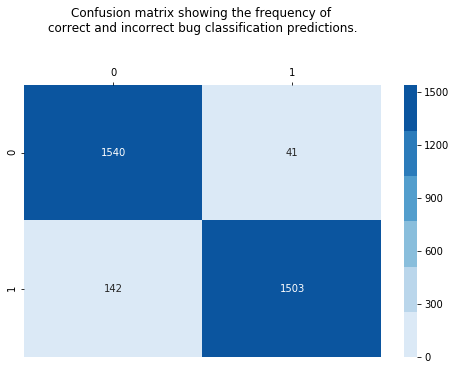

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test_rand, np.rint(y_predict_rand)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(
    y_test_rand.astype(int),
    np.rint(y_predict_rand),
)

In [0]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

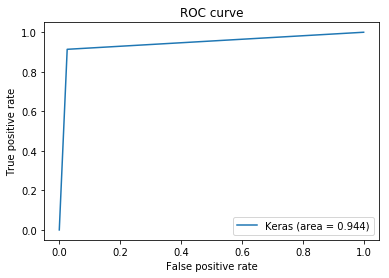

In [0]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    y_test_rand.astype(int), 
    np.rint(y_predict_rand)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

Testing on original test set:

In [0]:
test_batch_generator = SparseToDenseGenerator(x_test, y_test, batch_size)

model_rand.evaluate_generator(
    generator=test_batch_generator,
)

[0.213629653004113, 0.9076255446846118]